# Building a class for a player
I think that it would be very useful for us to wrap the functionality of the analysis into a class; one that we can just pass the link to the page and then we have access to all their details. 

In [1]:
# Required imports
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

### Initial workings
This notebook contains the workings of getting to the class, and I will save a version of the class in a `.py` file ([here](../CricketPlayer.py)) as well so we can easily import that into other notebooks later.  

The final version of the class is kept in that final class file linked above. 

In [2]:
class CricketPlayer:
    def __init__(self, innings_by_innings_link):
        self.link = innings_by_innings_link
        self.soup = BeautifulSoup(requests.get(innings_by_innings_link).text, features="html.parser")
        
    def view_raw_html(self):
        return(self.soup)
    
    def raw_innings(self):
        for caption in self.soup.find_all('caption'):
            if caption.get_text() == 'Innings by innings list':
                main_table = caption.find_parent('table', {'class': 'engineTable'})
                
        columns = [header.get_text() for header in main_table.find('thead').find_all('tr')[0].find_all('th')]
        rows = []

        for innings in [row for row in main_table.find('tbody').find_all('tr')]:
            rows.append([stat.get_text() for stat in innings.find_all('td')])
            
        return(pd.DataFrame(rows, columns=columns))
    
    def innings(self):
        raw_innings = self.raw_innings()
        raw_innings['Opposition'] = raw_innings['Opposition'].str.replace('v ', '')
        raw_innings.replace('-', np.nan, inplace=True)
        raw_innings.columns = raw_innings.columns.str.lower().str.replace(' ', '_')
        raw_innings['is_out'] = raw_innings.score.astype('str').apply(lambda x: False if x in ['nan', 'DNB'] else False if '*' in x else True)
        raw_innings['did_bowl'] = raw_innings.overs.astype('str').apply(lambda x: False if x in ['nan', 'DNB'] else True)
        raw_innings['did_bat'] = raw_innings.score.str.replace('*', '').astype('str').apply(lambda x: True if x.isnumeric() else False)
        raw_innings['score'] = raw_innings['score'].str.replace('*', '')
        return(raw_innings[['inns', 'score', 'did_bat', 'is_out', 'overs', 'conc', 'wkts', 'did_bowl', 'ct', 'st', 'opposition', 'ground', 'start_date']])
    
    def batting_summary(self):
        innings = self.innings()
        total_at_bats = innings.did_bat.sum()
        dismissals = innings.is_out.sum()
        total_runs = innings.score[innings.did_bat].dropna().astype('int').sum()
        return(pd.DataFrame({'Innings': total_at_bats, 
                             'Dismissals': dismissals, 
                             'Total Runs': total_runs, 
                             'Average': round(total_runs/dismissals, 4)}, index=['Overall']))
    
    
    def rolling_average_innings(self, n_innings):
        innings = self.innings()[self.innings().did_bat].set_index('start_date').loc[:, ['score', 'is_out']]
        innings.index = pd.to_datetime(innings.index)
        innings.score = innings.score.astype('int')
        rolling_innings = innings.rolling(n_innings).sum()
        rolling_innings['average'] = rolling_innings['score'] / rolling_innings['is_out']
        return(rolling_innings)
    
    def rolling_average_matches(self, n_matches):
        matches = self.innings()[self.innings().did_bat].set_index('start_date').loc[:, ['score', 'is_out']]
        matches.score = matches.score.astype('int')
        matches.index = pd.to_datetime(matches.index)
        matches = matches.groupby('start_date').sum()
        rolling_matches = matches.rolling(n_matches).sum()
        rolling_matches['average'] = rolling_matches['score'] / rolling_matches['is_out']
        return(rolling_matches)
    
    def accumulative_average(self):
        innings = self.innings()[self.innings().did_bat].set_index('start_date').loc[:, ['score', 'is_out']]
        innings.index = pd.to_datetime(innings.index)
        innings.score = innings.score.astype('int')
        innings['total_runs'] = innings.score.cumsum()
        innings['total_dismissals'] = innings.is_out.astype('int').cumsum()
        innings['running_average'] = innings.total_runs / innings.total_dismissals
        return(innings)

In [3]:
virat_kohli = 'http://stats.espncricinfo.com/ci/engine/player/253802.html?class=1;template=results;type=allround;view=innings'
steve_smith = 'http://stats.espncricinfo.com/ci/engine/player/267192.html?class=1;template=results;type=allround;view=innings'
kane_williamson = 'http://stats.espncricinfo.com/ci/engine/player/277906.html?class=1;template=results;type=allround;view=innings'
joe_root = 'http://stats.espncricinfo.com/ci/engine/player/303669.html?class=1;template=results;type=allround;view=innings'

In [4]:
root = CricketPlayer(joe_root)

In [5]:
innings = root.raw_innings()
innings

,Inns,Score,Overs,Conc,Wkts,Ct,St,,Opposition,Ground,Start Date,
0,1,73,-,-,-,-,-,,v India,Nagpur,13 Dec 2012,Test # 2066
1,2,-,1.0,5,0,0,0,,v India,Nagpur,13 Dec 2012,Test # 2066
2,3,20*,-,-,-,-,-,,v India,Nagpur,13 Dec 2012,Test # 2066
3,1,4,-,-,-,-,-,,v New Zealand,Dunedin,6 Mar 2013,Test # 2077
4,2,-,5.0,8,0,0,0,,v New Zealand,Dunedin,6 Mar 2013,Test # 2077
5,3,0,-,-,-,-,-,,v New Zealand,Dunedin,6 Mar 2013,Test # 2077
6,1,10,-,-,-,-,-,,v New Zealand,Wellington,14 Mar 2013,Test # 2080
7,2,-,1.0,6,0,0,0,,v New Zealand,Wellington,14 Mar 2013,Test # 2080
8,3,-,2.0,12,0,0,0,,v New Zealand,Wellington,14 Mar 2013,Test # 2080
9,1,-,2.0,5,0,0,0,,v New Zealand,Auckland,22 Mar 2013,Test # 2084


In [6]:
# Remove 'v ' from the beginning of each opposition
innings['Opposition'] = innings['Opposition'].str.replace('v ', '')

In [7]:
# Remove the empty columns that are used for spacing and links on the website 
innings.drop('', axis=1, inplace = True)
innings.head()

,Inns,Score,Overs,Conc,Wkts,Ct,St,Opposition,Ground,Start Date
0,1,73,-,-,-,-,-,India,Nagpur,13 Dec 2012
1,2,-,1.0,5,0,0,0,India,Nagpur,13 Dec 2012
2,3,20*,-,-,-,-,-,India,Nagpur,13 Dec 2012
3,1,4,-,-,-,-,-,New Zealand,Dunedin,6 Mar 2013
4,2,-,5.0,8,0,0,0,New Zealand,Dunedin,6 Mar 2013


I think we want to replace the blank '-' with `np.nan` to neaten up the output. 

In [8]:
import numpy as np
innings.replace('-', np.nan, inplace=True)

In [9]:
innings.head()

,Inns,Score,Overs,Conc,Wkts,Ct,St,Opposition,Ground,Start Date
0,1,73,NaN,NaN,NaN,NaN,NaN,India,Nagpur,13 Dec 2012
1,2,NaN,1.0,5,0,0,0,India,Nagpur,13 Dec 2012
2,3,20*,NaN,NaN,NaN,NaN,NaN,India,Nagpur,13 Dec 2012
3,1,4,NaN,NaN,NaN,NaN,NaN,New Zealand,Dunedin,6 Mar 2013
4,2,NaN,5.0,8,0,0,0,New Zealand,Dunedin,6 Mar 2013


Clean up the column names. 

In [10]:
innings.columns = innings.columns.str.lower().str.replace(' ', '_')

In [11]:
innings.head()

,inns,score,overs,conc,wkts,ct,st,opposition,ground,start_date
0,1,73,NaN,NaN,NaN,NaN,NaN,India,Nagpur,13 Dec 2012
1,2,NaN,1.0,5,0,0,0,India,Nagpur,13 Dec 2012
2,3,20*,NaN,NaN,NaN,NaN,NaN,India,Nagpur,13 Dec 2012
3,1,4,NaN,NaN,NaN,NaN,NaN,New Zealand,Dunedin,6 Mar 2013
4,2,NaN,5.0,8,0,0,0,New Zealand,Dunedin,6 Mar 2013


It will be easier if we have a flag for working out whether the batsman got out or not. 

In [12]:
innings['is_out'] = innings.score.astype('str').apply(lambda x: np.nan if x == 'nan' else False if '*' in x else True)

In [13]:
innings.head()

,inns,score,overs,conc,wkts,ct,st,opposition,ground,start_date,is_out
0,1,73,NaN,NaN,NaN,NaN,NaN,India,Nagpur,13 Dec 2012,True
1,2,NaN,1.0,5,0,0,0,India,Nagpur,13 Dec 2012,NaN
2,3,20*,NaN,NaN,NaN,NaN,NaN,India,Nagpur,13 Dec 2012,False
3,1,4,NaN,NaN,NaN,NaN,NaN,New Zealand,Dunedin,6 Mar 2013,True
4,2,NaN,5.0,8,0,0,0,New Zealand,Dunedin,6 Mar 2013,NaN


Add a flag to indicate whether the player bowled in that particular innings. 

In [14]:
innings['did_bowl'] = innings.overs.astype('str').apply(lambda x: False if x in ['nan', 'DNB'] else True)

In [15]:
innings[['inns', 'score', 'is_out', 'overs', 'conc', 
         'wkts', 'did_bowl', 'ct', 'st', 'opposition', 'ground', 'start_date']].head()

,inns,score,is_out,overs,conc,wkts,did_bowl,ct,st,opposition,ground,start_date
0,1,73,True,NaN,NaN,NaN,False,NaN,NaN,India,Nagpur,13 Dec 2012
1,2,NaN,NaN,1.0,5,0,True,0,0,India,Nagpur,13 Dec 2012
2,3,20*,False,NaN,NaN,NaN,False,NaN,NaN,India,Nagpur,13 Dec 2012
3,1,4,True,NaN,NaN,NaN,False,NaN,NaN,New Zealand,Dunedin,6 Mar 2013
4,2,NaN,NaN,5.0,8,0,True,0,0,New Zealand,Dunedin,6 Mar 2013


Cleaned up `raw_innings()` so that we have another function that returns a clean `pd.DataFrame`. 

In [16]:
innings['did_bat'] = innings.score.str.replace('*', '').astype('str').apply(lambda x: True if x.isnumeric() else False)

We can check that this correctly filters out the 'DNB' values. 

In [17]:
innings[innings.score == 'DNB']

,inns,score,overs,conc,wkts,ct,st,opposition,ground,start_date,is_out,did_bowl,did_bat
89,4,DNB,NaN,NaN,NaN,NaN,NaN,West Indies,St George's,21 Apr 2015,True,False,False
153,4,DNB,NaN,NaN,NaN,NaN,NaN,Sri Lanka,Chester-le-Street,27 May 2016,True,False,False
226,4,DNB,NaN,NaN,NaN,NaN,NaN,West Indies,Lord's,7 Sep 2017,True,False,False


In [18]:
# Innings that he didn't bat 
root.innings()[np.invert(root.innings().did_bat)].shape

(167, 13)

In [19]:
# Innings that he did bat 
root.innings()[root.innings().did_bat].shape

(161, 13)

In [20]:
# Total shape of data
root.innings().shape

(328, 13)

In [21]:
not_outs = root.innings()[(root.innings().did_bat) & np.invert(root.innings().is_out)]

We can join back into the raw scraping from the website to check that our not out flag is working correctly. 

In [22]:
root.raw_innings().iloc[not_outs.index]

,Inns,Score,Overs,Conc,Wkts,Ct,St,,Opposition,Ground,Start Date,
2,3,20*,-,-,-,-,-,,v India,Nagpur,13 Dec 2012,Test # 2066
32,4,13*,-,-,-,-,-,,v Australia,Manchester,1 Aug 2013,Test # 2092
44,4,26*,-,-,-,-,-,,v Australia,Brisbane,21 Nov 2013,Test # 2103
57,1,200*,-,-,-,-,-,,v Sri Lanka,Lord's,12 Jun 2014,Test # 2124
66,2,154*,-,-,-,-,-,,v India,Nottingham,9 Jul 2014,Test # 2128
80,2,149*,-,-,-,-,-,,v India,The Oval,15 Aug 2014,Test # 2137
87,2,182*,-,-,-,-,-,,v West Indies,St George's,21 Apr 2015,Test # 2158
113,4,38*,-,-,-,-,-,,v Australia,Birmingham,29 Jul 2015,Test # 2173
123,4,33*,-,-,-,-,-,,v Pakistan,Abu Dhabi,13 Oct 2015,Test # 2180
142,4,4*,-,-,-,-,-,,v South Africa,Johannesburg,14 Jan 2016,Test # 2199


In [23]:
root.raw_innings().iloc[root.innings()[root.innings().did_bat].index]

,Inns,Score,Overs,Conc,Wkts,Ct,St,,Opposition,Ground,Start Date,
0,1,73,-,-,-,-,-,,v India,Nagpur,13 Dec 2012,Test # 2066
2,3,20*,-,-,-,-,-,,v India,Nagpur,13 Dec 2012,Test # 2066
3,1,4,-,-,-,-,-,,v New Zealand,Dunedin,6 Mar 2013,Test # 2077
5,3,0,-,-,-,-,-,,v New Zealand,Dunedin,6 Mar 2013,Test # 2077
6,1,10,-,-,-,-,-,,v New Zealand,Wellington,14 Mar 2013,Test # 2080
10,2,45,-,-,-,-,-,,v New Zealand,Auckland,22 Mar 2013,Test # 2084
12,4,29,-,-,-,-,-,,v New Zealand,Auckland,22 Mar 2013,Test # 2084
13,1,40,-,-,-,-,-,,v New Zealand,Lord's,16 May 2013,Test # 2088
15,3,71,-,-,-,-,-,,v New Zealand,Lord's,16 May 2013,Test # 2088
17,1,104,-,-,-,-,-,,v New Zealand,Leeds,24 May 2013,Test # 2089


We can use the clean data, with our defined flags to generate a summary data frame for the entire innings set. 

In [24]:
root.batting_summary()

,Innings,Dismissals,Total Runs,Average
Overall,161,149,7056,47.3557


In [25]:
start_date_innings = root.innings().set_index('start_date')

In [26]:
start_date_innings.index = pd.to_datetime(start_date_innings.index)
start_date_innings.index

DatetimeIndex(['2012-12-13', '2012-12-13', '2012-12-13', '2013-03-06',
               '2013-03-06', '2013-03-06', '2013-03-14', '2013-03-14',
               '2013-03-14', '2013-03-22',
               ...
               '2019-09-04', '2019-09-04', '2019-09-04', '2019-09-12',
               '2019-09-12', '2019-09-12', '2019-09-12', '2019-11-21',
               '2019-11-21', '2019-11-21'],
              dtype='datetime64[ns]', name='start_date', length=328, freq=None)

In [27]:
start_date_innings.head()

,inns,score,did_bat,is_out,overs,conc,wkts,did_bowl,ct,st,opposition,ground
start_date,,,,,,,,,,,,
2012-12-13,1,73,True,True,NaN,NaN,NaN,False,NaN,NaN,India,Nagpur
2012-12-13,2,NaN,False,False,1.0,5,0,True,0,0,India,Nagpur
2012-12-13,3,20,True,False,NaN,NaN,NaN,False,NaN,NaN,India,Nagpur
2013-03-06,1,4,True,True,NaN,NaN,NaN,False,NaN,NaN,New Zealand,Dunedin
2013-03-06,2,NaN,False,False,5.0,8,0,True,0,0,New Zealand,Dunedin


Having this format will allow us to rank the innings by the match using the `start_date` index. 

In [28]:
rolling_15 = root.rolling_average_innings(15)
rolling_15

,score,is_out,average
start_date,,,
2012-12-13,NaN,NaN,NaN
2012-12-13,NaN,NaN,NaN
2013-03-06,NaN,NaN,NaN
2013-03-06,NaN,NaN,NaN
2013-03-14,NaN,NaN,NaN
2013-03-22,NaN,NaN,NaN
2013-03-22,NaN,NaN,NaN
2013-05-16,NaN,NaN,NaN
2013-05-16,NaN,NaN,NaN


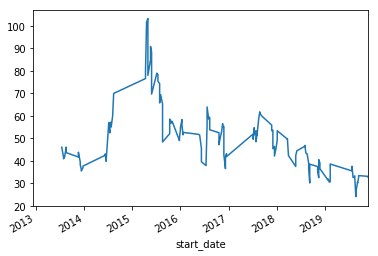

In [29]:
rolling_15.average.plot()
plt.show()

In [30]:
rolling_15_matches = root.rolling_average_matches(15)
rolling_15_matches.tail(25)

,score,is_out,average
start_date,,,
2017-12-14,1396.0,28.0,49.857143
2017-12-26,1329.0,27.0,49.222222
2018-01-04,1392.0,26.0,53.538462
2018-03-22,1350.0,26.0,51.923077
2018-03-30,1343.0,26.0,51.653846
2018-05-24,1321.0,26.0,50.807692
2018-06-01,1171.0,25.0,46.840000
2018-08-01,1179.0,25.0,47.160000
2018-08-09,1119.0,24.0,46.625000


In [31]:
first_date = min(rolling_15_matches.index)
first_date_average = min(rolling_15_matches[rolling_15_matches.score > 0].index)
starting_average = rolling_15_matches.loc[first_date_average, 'average']
max_date = max(rolling_15_matches.index)

from datetime import datetime
now = datetime.now()
captaincy_start = datetime(2017, 2, 13)

Visualise the performance of Root since he became the captain of England.

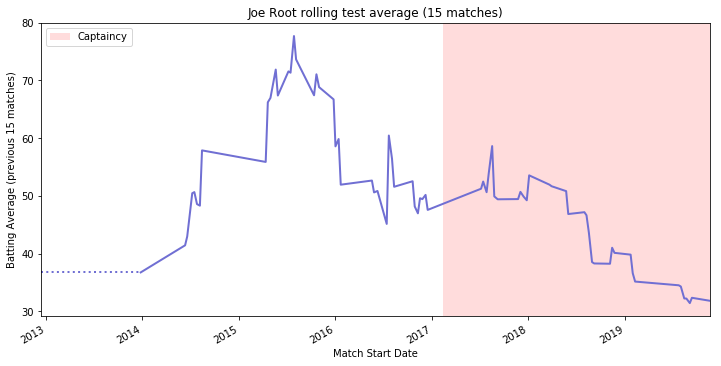

In [32]:
plt.figure(figsize=(12,6))
rolling_15_matches.average.plot(color='#706fd3', label='_nolegend_', linewidth=2)
plt.plot([first_date, first_date_average], [starting_average, starting_average], linestyle=':', color='#706fd3', label='_nolegend_', linewidth=2)
plt.title('Joe Root rolling test average (15 matches)')
plt.xlabel('Match Start Date')
plt.ylabel('Batting Average (previous 15 matches)')
# 13 February 2017
plt.axvspan(captaincy_start, now, facecolor='#ff5252', alpha=0.2, label = 'Captaincy')
plt.legend()
plt.show()

In [33]:
virat_kohli = 'http://stats.espncricinfo.com/ci/engine/player/253802.html?class=1;template=results;type=allround;view=innings'
steve_smith = 'http://stats.espncricinfo.com/ci/engine/player/267192.html?class=1;template=results;type=allround;view=innings'
kane_williamson = 'http://stats.espncricinfo.com/ci/engine/player/277906.html?class=1;template=results;type=allround;view=innings'
joe_root = 'http://stats.espncricinfo.com/ci/engine/player/303669.html?class=1;template=results;type=allround;view=innings'

kohli = CricketPlayer(virat_kohli)
smith = CricketPlayer(steve_smith)
kane = CricketPlayer(kane_williamson)

In [34]:
r15_kohli = kohli.rolling_average_matches(15).average
r15_smith = smith.rolling_average_matches(15).average
r15_kane = kane.rolling_average_matches(15).average

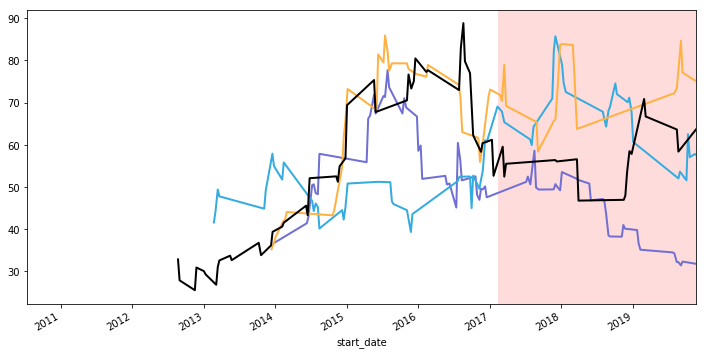

In [35]:
plt.figure(figsize=(12,6))
rolling_15_matches.average.plot(color='#706fd3', label='_nolegend_', linewidth=2)
r15_kohli.plot(color='#34ace0', label='_nolegend_', linewidth=2)
r15_smith.plot(color='#ffb142', label='_nolegend_', linewidth=2)
r15_kane.plot(color='black', label='_nolegend_', linewidth=2)
plt.axvspan(captaincy_start, now, facecolor='#ff5252', alpha=0.2, label = 'Captaincy')
plt.show()

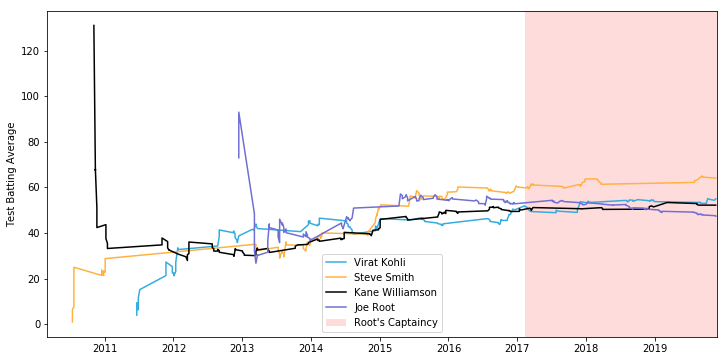

In [53]:
plt.figure(figsize=(12,6))
plt.plot(kohli.accumulative_average().running_average, label = 'Virat Kohli', color='#34ace0')
plt.plot(smith.accumulative_average().running_average, label='Steve Smith', color='#ffb142')
plt.plot(kane.accumulative_average().running_average, label='Kane Williamson', color='black')
plt.plot(root.accumulative_average().running_average, label='Joe Root', color='#706fd3')
plt.axvspan(captaincy_start, now, facecolor='#ff5252', alpha=0.2, label = 'Root\'s Captaincy')
plt.legend()
start = datetime(2010, 3, 1)
plt.xlim(start, now)
plt.ylabel('Test Batting Average')
plt.savefig('top_4_over_time.jpeg')

In [58]:
root.accumulative_average().loc[captaincy_start:now]

,score,is_out,total_runs,total_dismissals,running_average
start_date,,,,,
2017-07-06,190,True,4784,88,54.363636
2017-07-06,5,True,4789,89,53.808989
2017-07-14,78,True,4867,90,54.077778
2017-07-14,8,True,4875,91,53.571429
2017-07-27,29,True,4904,92,53.304348
2017-07-27,50,True,4954,93,53.268817
2017-08-04,52,True,5006,94,53.255319
2017-08-04,49,True,5055,95,53.210526
2017-08-17,136,True,5191,96,54.072917


In [81]:
at_bats = root.innings()[root.innings().did_bat]

In [83]:
at_bats['fifty'] = at_bats.score.astype('int').between(50,99, inclusive=True)
at_bats['century'] = at_bats.score.astype('int').ge(100)
at_bats

,inns,score,did_bat,is_out,overs,conc,wkts,did_bowl,ct,st,opposition,ground,start_date,fifty,century
0,1,73,True,True,NaN,NaN,NaN,False,NaN,NaN,India,Nagpur,13 Dec 2012,True,False
2,3,20,True,False,NaN,NaN,NaN,False,NaN,NaN,India,Nagpur,13 Dec 2012,False,False
3,1,4,True,True,NaN,NaN,NaN,False,NaN,NaN,New Zealand,Dunedin,6 Mar 2013,False,False
5,3,0,True,True,NaN,NaN,NaN,False,NaN,NaN,New Zealand,Dunedin,6 Mar 2013,False,False
6,1,10,True,True,NaN,NaN,NaN,False,NaN,NaN,New Zealand,Wellington,14 Mar 2013,False,False
10,2,45,True,True,NaN,NaN,NaN,False,NaN,NaN,New Zealand,Auckland,22 Mar 2013,False,False
12,4,29,True,True,NaN,NaN,NaN,False,NaN,NaN,New Zealand,Auckland,22 Mar 2013,False,False
13,1,40,True,True,NaN,NaN,NaN,False,NaN,NaN,New Zealand,Lord's,16 May 2013,False,False
15,3,71,True,True,NaN,NaN,NaN,False,NaN,NaN,New Zealand,Lord's,16 May 2013,True,False
17,1,104,True,True,NaN,NaN,NaN,False,NaN,NaN,New Zealand,Leeds,24 May 2013,False,True


In [86]:
at_bats.set_index('start_date', inplace=True)

In [88]:
at_bats.index = pd.to_datetime(at_bats.index)

In [102]:
conversion = at_bats[['fifty', 'century']].astype('int').cumsum()

In [105]:
conversion['rate'] = conversion['century'] / (conversion['fifty'] + conversion['century'])

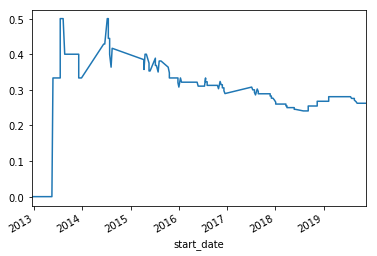

In [108]:
conversion.rate.plot()
plt.show()